# Fit FELTOR magnetic field coefficients to experimental equilibrium

This notebook explains a possible way to convert an experimental magnetic field equilibrium to an input file for FELTOR. 

**Read up on how FELTOR sets up the magnetic flux in the documentation "feltor/src/feltor/feltor.tex" (compile to pdf)** 

Here, we assume that we have given a matlab file containing an experimental profile from TCV that we want to fit using FELTOR's polynomial fit.

## Explore experimental data

First we want to explore the experimental data a bit

In [1]:
import numpy as np
import json
import scipy.io
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
# First we load the matlab file
file = "eq_TCV"

mat = scipy.io.loadmat(file+'.mat')

# and display its content
scipy.io.whosmat(file+'.mat')

[('eq', (1, 1), 'struct')]

In [3]:
# The 'eq' struct is a structured ndarray and contains several variables
mat['eq'].dtype.names

('Bpol', 'Bphi', 'R', 'Z', 'psi', 'BR', 'BZ', 'R_wall', 'Z_wall')

In [4]:
# Let us load the data 
print( "Loading data ... ")
# The first two 0s are because of how the data is stored
R= mat['eq']['R'][0][0][:,:]
Z= mat['eq']['Z'][0][0][:,:]
Psi = mat['eq']['psi'][0][0][:,:]
BR = mat['eq']['BR'][0][0][:,:]
BZ = mat['eq']['BZ'][0][0][:,:]
Bpol = mat['eq']['Bpol'][0][0][:,:]
Bphi = mat['eq']['Bphi'][0][0][:,:]
R_wall = mat['eq']['R_wall'][0][0] # not used for now
Z_wall = mat['eq']['Z_wall'][0][0] # not used for now
print(R.shape)

Loading data ... 
(1520, 540)


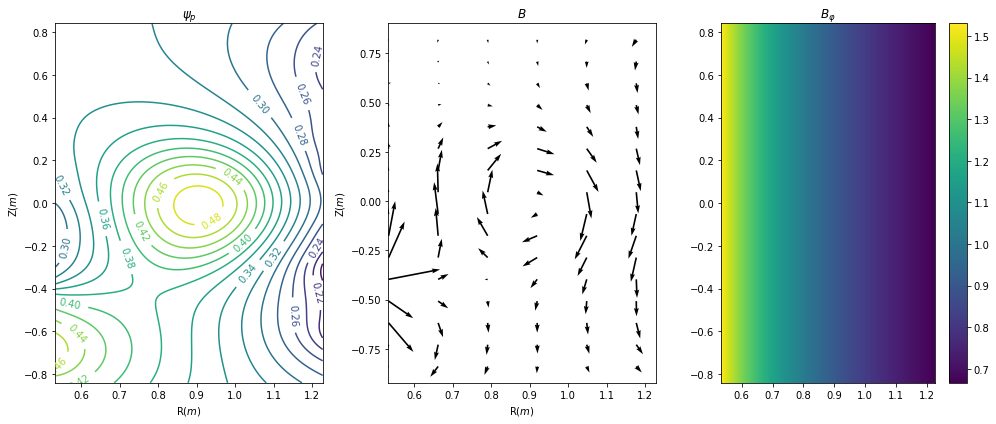

In [5]:
# Now let us plot the flux function 
# which is what we want to fit
# and the B - field

fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(14,6), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,Psi,15)
ax.clabel(cf)
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$\psi_p$')
ax = axes[0][1]
q = ax.quiver(R[::100,::100],Z[::100,::100],BR[::100,::100],BZ[::100,::100],
              units="width")
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$B$')
ax = axes[0][2]
cf = ax.pcolormesh(R,Z,Bphi)
fig.colorbar(cf,ax=ax)
ax.set_title(r'$B_\varphi$')
fig.tight_layout()

plt.show()

In [6]:
# Let us also print the location of the O-point
o_point = np.where( Psi == np.min(Psi))

if abs(Bpol[o_point]/Bphi[o_point]) > 0.01 :
    o_point = np.where( Psi == np.max(Psi))
if abs(Bpol[o_point]/Bphi[o_point]) > 0.01 :
    print( "O-point not found!")
print("O-point at (R_O,Z_O) = ",R[o_point], Z[o_point])

O-point at (R_O,Z_O) =  [0.90557141] [-0.00940092]


## Orientation and consistency

From an external documentation we know that the data bases on Cylindrical right handed coordinate system $R,\varphi,Z$ (i.e. $\hat e_\varphi$ is **anti-clock wise** if viewed from the top) 
and the magnetic field is given by
\begin{align}
\vec B = \frac{1}{R}\left( I \hat e_\varphi + \vec \nabla \psi \times \hat e_\varphi \right) = \frac{1}{R}\left( I \hat e_\varphi - \frac{\partial \psi}{\partial Z} \hat e_R + \frac{\partial \psi}{\partial R} \hat e_Z \right)
\end{align}

From the above plot we realize that with $B_\varphi >0$ **the toroidal field is anti-clockwise** if viewed from the top, with gradB of ions upwards, un-favourable for H-mode. Together with the poloidal field we have a **right handed winding**.

First we test if the contained magnetic field is consistent with the flux function and fulfills
\begin{align}
B_R = -\frac{1}{R} \frac{\partial \psi}{\partial Z} \\
B_Z = +\frac{1}{R} \frac{\partial \psi}{\partial R} 
\end{align}

In [7]:
# Numerically derive
dPsidZ = np.diff( Psi, axis=0)/np.diff( Z, axis=0)
dPsidR = np.diff( Psi, axis=1)/np.diff( R, axis=1)
dPsidZ=np.append(np.zeros((1,(np.shape(Psi)[1]))),dPsidZ, axis=0)
dPsidR=np.append(np.zeros(((np.shape(Psi)[0]),1)),dPsidR, axis=1)
#print( np.shape(dPsidz))
BR_num = -1/R*dPsidZ
BZ_num =  1/R*dPsidR

# print the first element
print(abs(BR[1,0]-BR_num[1,0])/BR[1,0])
print(abs(BZ[1,1]-BZ_num[1,1])/BZ[1,1])

-5.246362097555394
-5.083237805536858


We see that the numerical derivative is different from the stored magnetic field. Through some experimentation we find out that there is a factor $2\pi$ in Psi that we need to divide.


In [8]:
Psi = Psi/2/np.pi

In [9]:
# Numerically derive
dPsidZ = np.diff( Psi, axis=0)/np.diff( Z, axis=0)
dPsidR = np.diff( Psi, axis=1)/np.diff( R, axis=1)
dPsidZ=np.append(np.zeros((1,(np.shape(Psi)[1]))),dPsidZ, axis=0)
dPsidR=np.append(np.zeros(((np.shape(Psi)[0]),1)),dPsidR, axis=1)
#print( np.shape(dPsidz))
BR_num = -1/R*dPsidZ
BZ_num =  1/R*dPsidR

# print the first element
print(abs(BR[1,0]-BR_num[1,0])/BR[1,0])
print(abs(BZ[1,1]-BZ_num[1,1])/BZ[1,1])

-0.005860595832182501
-0.031822633245204346


We consider the remaining difference negligible.

## Normalization and Transformtion

The first task is to normalize the data. FELTOR's polynomial 
fit uses
\begin{align}
 \frac{\psi}{B_0R_0 \rho_s} = P_\psi \frac{R_0}{\rho_s}\sum_{ij=1}^{N_R,N_Z} c_{ij}\left(\frac{R}{R_0}\right)^i \left(\frac{Z}{R_0}\right)^j
 \end{align}
 where $\rho_s$ is an arbitrary simulation length scale. All magnetic coefficients are normalized with $\rho_s = 1$m (Feltor takes care of renormalization if $\rho_s$ changes).
 
 This means we need to renormalize the dimensional experimental data.
 First we choose $R_0$ and $B_0$ to be the O-point values.
 Since these are only normalization coefficients their exact
 values are not important

In [10]:

R0 = np.round( R[o_point][0], decimals=2)
B0 = np.round(
    np.sqrt(Bphi[o_point]**2 + Bpol[o_point]**2)[0],
    decimals=2)
print(R0, B0)
# As minor radius we estimate from the above figure
a = 0.25 

0.91 0.9


The $P_\psi$ coefficient can be used to later change the direction
of the poloidal field

In [11]:
PP = 1

The next point is that FELTOR wants the O-point to be close to $(R_0, 0)$
Therefore we move the $Z$ coordinate

In [12]:
Z0 = np.round( Z[o_point][0], decimals=1)
print(Z0)

-0.0


Next, we need to consider that FELTOR's coordinate system is a 
right-handed $(R,Z,\varphi')$ (instead of $(R,\varphi,Z)$, which means that FELTOR's $\hat e_\varphi' = - \hat e_\varphi$ points **clockwise** if viewed from the top and we have
  \begin{align}
\vec B = \frac{1}{R}\left( I \hat e_\varphi' + \vec \nabla \psi \times \hat e_\varphi' \right) = \frac{1}{R}\left( I \hat e_\varphi' + \frac{\partial \psi}{\partial Z} \hat e_R - \frac{\partial \psi}{\partial R} \hat e_Z \right)
\end{align} 

We thus need to make the identification
\begin{align}
\psi \rightarrow -\psi \\
I \rightarrow -I \\
B_\varphi \rightarrow - B_\varphi
\end{align}

Now, reread the data with normalizations. In this way we avoid double normalization if we execute the cell twice by accident.

In [13]:
# Normalization
R= mat['eq']['R'][0][0][:,:]
Z= mat['eq']['Z'][0][0][:,:] - Z0
Psi = -mat['eq']['psi'][0][0][:,:]/2/np.pi/R0/B0
BR = mat['eq']['BR'][0][0][:,:]/B0
BZ = mat['eq']['BZ'][0][0][:,:]/B0
Bpol = mat['eq']['Bpol'][0][0][:,:]/B0
Bphi = -mat['eq']['Bphi'][0][0][:,:]/B0

Now, everything is in FELTOR coordinates.

## The fit

First we need to define the fit function in python and fit the coefficients. In order to accelerate the fit it is also a good idea
to not take all points. It is sufficient to only take every 10th point say

In [14]:
miny=0 # 100
maxy=-1 # 1300
minx=0 # 40
maxx=-1 #540
every=5
Rred= R[miny:maxy:every,minx:maxx:every]
Zred= Z[miny:maxy:every,minx:maxx:every]
Psired = Psi[miny:maxy:every,minx:maxx:every]

Bphired = Bphi[miny:maxy:every,minx:maxx:every]


In [15]:
from pyfeltor import dg
# The degree of the polynomial determines how long the fitting
# takes but also how good the fit will be
degR = 8
degZ = 16
params = dg.geo.polynomial.Parameters ()
params.R_0 = R0
params.pp = 1
params.M = degR  # degree in R
params.N = degZ # degree in Z

def psi_ana( x, *c):
#    print(x)
    R , Z = x

    params.c = list(c)

    psip = dg.geo.polynomial.Psip(params)
    return psip(R,Z)
    


In [16]:
# With this function we can experiment to weigh the fitting 
# Let's ignore it for now

def sigma ( x): 
    # if x < 0.07:
    #     return 10000 #basically removes these points from fit
    # if x > 0.56/2/np.pi:
    #     return 1
    # else:
        return 1

In [17]:
c = np.array( np.zeros(degR*degZ))

#We need to ravel the meshgrids of X, Y points
# to a pair of 1-D arrays:
coords = np.vstack((Rred.ravel(),Zred.ravel()))
psip_exp = Psired.ravel()
# in case we have a sigma
weights = np.array([sigma(psi) for psi in psip_exp])


In [18]:
import time
start = time.monotonic()
# Here comes the fit (might take a while)
copt, pcov = curve_fit(psi_ana, coords, psip_exp,c,weights)   
stop = time.monotonic()
print( "Took / s", stop - start)
print( copt)

Took / s 24.959734952997678
[-2.32477802e+00 -3.62443827e+00  2.91069862e+01  1.38264444e+01
 -6.96796962e+01 -5.65201141e+00 -4.98606118e+01 -6.01065942e+01
  6.46261202e+02  1.08452462e+02 -1.80352952e+03  2.75916340e+00
  2.20775473e+03 -7.53711155e+01 -9.64914931e+02  4.89567740e+00
  2.23834063e+01  2.30207588e+01 -2.53039735e+02 -8.02117944e+01
  6.09631838e+02  8.14602633e+01 -2.65033260e+02  2.61484896e+01
 -1.62000843e+03  1.38284590e+02  6.47782029e+03 -8.81236608e+02
 -9.64372262e+03  8.03935574e+02  4.70448816e+03 -3.78967238e-01
 -9.05175667e+01 -6.12748025e+01  9.17243402e+02  1.74008656e+02
 -2.01718372e+03 -1.75817174e+02  1.29098568e+03  2.04377114e+02
 -6.56980618e-02 -9.80577002e+02 -6.47817578e+03  2.64510377e+03
  1.54110517e+04 -1.79247015e+03 -9.08313320e+03 -3.56932708e+02
  1.95958344e+02  8.62052129e+01 -1.79757865e+03 -1.52428877e+02
  3.24201821e+03 -1.36653757e-01 -1.34385566e+02 -6.08516427e+01
  3.18563780e+02  8.48640174e+02  4.20046321e+00 -2.48633510e+

Let's see how good the fit is

In [19]:
coords = np.vstack((R.ravel(),Z.ravel()))
psip_ana = psi_ana( coords, *copt)
psip_ana = psip_ana.reshape( R.shape)
difference = psip_ana-Psi
print("Relative Error in Psi is      ",
      np.linalg.norm(difference, ord=2)/np.linalg.norm(
          Psi.ravel(), ord=2))

Relative Error in Psi is       0.001368585478110939


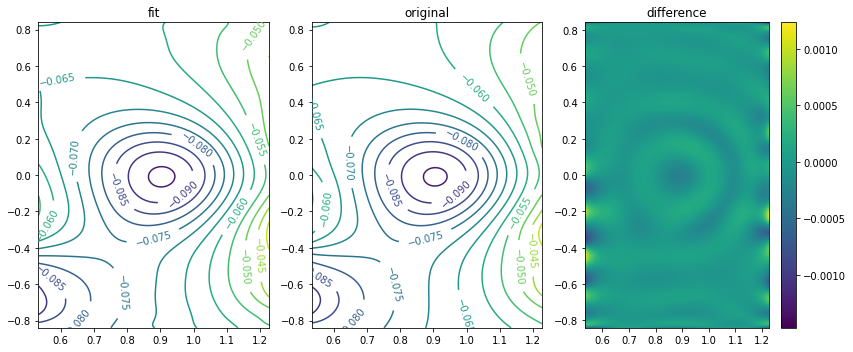

In [20]:
# Plot the numerical result, the original Psi and the difference
# In NORMALIZED UNITS
fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(12,5), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,psip_ana,11)
ax.clabel(cf)
ax.set_title('fit')
ax = axes[0][1]
cf = ax.contour(R,Z,Psi,11)
ax.clabel(cf)
ax.set_title('original')
ax = axes[0][2]
cf = ax.pcolormesh(R,Z,(psip_ana-Psi))
ax.set_title('difference')
fig.colorbar(cf,ax=ax)
fig.tight_layout()

plt.show()

## The toroidal B
In the polynomial FELTOR fit the toroidal field is simply given by
\begin{align}
\frac{B_t}{B_0} = \frac{P_IR_0}{R} \hat e_\varphi'
\end{align}
Where $P_I= \pm \frac{I}{R_0 B_0}$ gives the direction of the field

In [21]:
PI = (Bphi[o_point]/R0*R[o_point])[0]
PI


-0.9979430397788247

In [22]:
#Bphi_ana = np.sqrt( 1-2*copt[13]/copt[12]**2 *psip_num)#/coords[0]
Bphi_ana = PI*R0/R
difference = Bphi - Bphi_ana
print("Relative Error in Bphi is      ",
      np.linalg.norm(difference, ord=2)/np.linalg.norm(
          Bphi.ravel(), ord=2))
Bphi_ana = Bphi_ana.reshape( R.shape)
#source = source.reshape( R.shape)

Relative Error in Bphi is       1.0127906190331977e-16


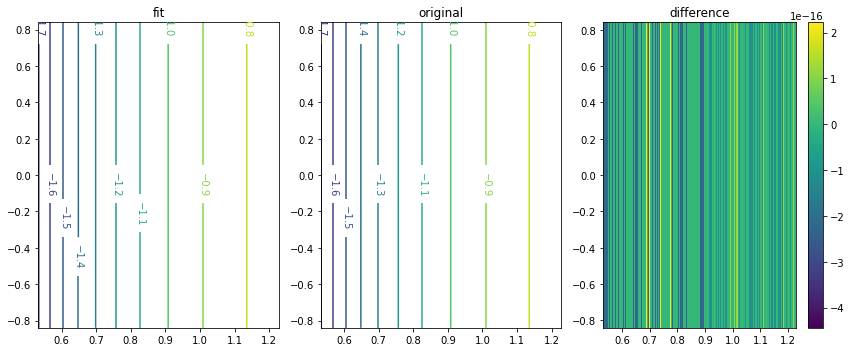

In [23]:
# Plot the numerical result
fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(12,5), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,Bphi_ana,11)
ax.clabel(cf)
ax.set_title('fit')
ax = axes[0][1]
cf = ax.contour(R,Z,Bphi,11)
ax.set_title('original')
ax.clabel(cf)
ax = axes[0][2]
pc = ax.pcolormesh(R,Z,(Bphi_ana-Bphi))
ax.set_title('difference')
fig.colorbar(pc,ax=ax)
fig.tight_layout()

plt.show()

We see that the toroidal magnetic field fits very well

## Final Steps

We are now ready to write the coefficients to a file.
Read the documentation of
[`dg::geo::createMagneticField`](https://mwiesenberger.github.io/feltor/geometries/html/group__geom.html#gaa0da1d1c2db65f1f4b28d77307ad238b) to find out about valid fields in your `json` file

In [24]:
outfile = "enrx_tcv.json"
elongation = 1.5 # an estimation from external source
triangularity = 0.4 # an estimation from external source
comment = "least squares fit; Matlab geometry file of TCV equilibrium for Enabling research project: X-point"
geom_file = {
    "M" : degR, "N": degZ,  "c": copt.tolist(), 
    "PP": PP, 
    "PI": PI, 
    "R_0": R0, # R0 in m
    "elongation": elongation, 
    "triangularity": triangularity,
    "inverseaspectratio": a/R0,
    "equilibrium" : "polynomial", # the fit function we used
    "description": "standardX", # we only have one X-point
    "comment" : comment
}


## Don't forget
FELTOR wants the X-point to lie on the $\psi_p=0$ line.
To this end we need
to find the X-point and subtract the $\psi_X$ value
from the $c_{00}$ coefficient.

In [25]:
mag = dg.geo.createMagneticField( geom_file)
psip = mag.get_psip()
RX = R0-1.1*0.3*a
ZX = -1.1*1.6*a
RO = R0
ZO = 0
point,RO,ZO = dg.geo.findOpoint( psip, RO,ZO)
print( "O-point found at", RO, ZO, "of type", point , "(1 min, 2 max)")
RX, ZX = dg.geo.findXpoint( psip, RX, ZX)
psipX = mag.psip()(RX,ZX)
print( "X-point at ", RX, ZX, " with value ", psipX)
# Update the zero coefficient
geom_file["c"][0] = copt[0] - psipX/PP/R0

O-point found at 0.9044339748965801 -0.008812684227755002 of type 1 (1 min, 2 max)
X-point at  0.7594073148311226 -0.41553708937149075  with value  -0.07418741647027706


In [26]:
# print(json.dumps(geom_file, indent=4))
with open(outfile, 'w') as f:
    print( json.dumps(geom_file, indent=4), file=f)


## Final Checks
Now, as a final check we can plot the magnetic field from the file we just created

In [27]:
mag = dg.geo.createMagneticField( geom_file)
Psi = mag.psip()(R,Z)
BR = dg.geo.BFieldR(mag)(R,Z)
BZ = dg.geo.BFieldZ(mag)(R,Z)
Bphi = dg.geo.BFieldP(mag)(R,Z)*R # BFieldP is the contravariant component

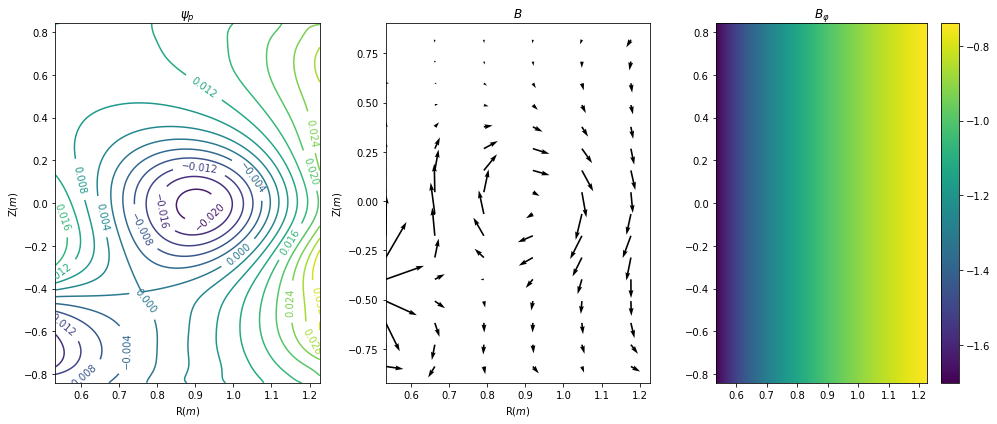

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(14,6), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,Psi,15)
ax.clabel(cf)
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$\psi_p$')
ax = axes[0][1]
q = ax.quiver(R[::100,::100],Z[::100,::100],BR[::100,::100],BZ[::100,::100],
              units="width")
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$B$')
ax = axes[0][2]
cf = ax.pcolormesh(R,Z,Bphi)
fig.colorbar(cf,ax=ax)
ax.set_title(r'$B_\varphi$')
fig.tight_layout()

plt.show()

### q-profile

Note that we have 
\begin{align}
\psi_t = \int^{\psi_p} q(\psi_p)  d\psi_p
\end{align}

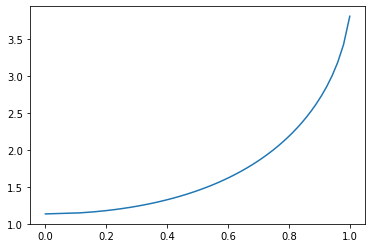

The q 95 value is 3.006857167001452


In [29]:
qfunctor = dg.geo.SafetyFactor(mag)
# Our psip values go from psipO to 0 
psipO = mag.psip()(RO,ZO)
# avoid being too close to the O-point and the separatrix
if ( psipO > 0):
    psi_values = np.linspace(psipO-1e-8,0,50, endpoint=False)
else:
    psi_values = np.linspace(psipO+1e-8,0,50, endpoint=False)
rhop= np.sqrt( (psipO -  psi_values)/psipO)
# print(qfunctor(psi_values))
qprof = qfunctor(psi_values)
psit = [np.trapz( qprof[0:i+1], psi_values[0:i+1]) for i in range( 0,np.size(psi_values))]

# plt.plot(rhop , psit)
rhot = np.sqrt( psit/psit[-1])
plt.plot(rhot , qprof)
plt.show()
idx = np.abs(rhot[:] - 0.95).argmin()
q95 = qprof[idx]
print( "The q 95 value is", q95)

If everything went well the geometry file is now ready to use; WELL DONE!! 